# MMI 701: Multimedia Signal Processing
## Sampling and Interpolation

- We will need several modules. Let us import them!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as spsig

- We will first try to emulate a continuous-time sinc function which is the **ideal interpolation function**. For that we will have time instances that are four orders of magnitude larger than the sampling period.
- We will then show that except at $t=0$, sinc has zeros at $t=nT$.

Text(0.5,1,'Ideal interpolation function')

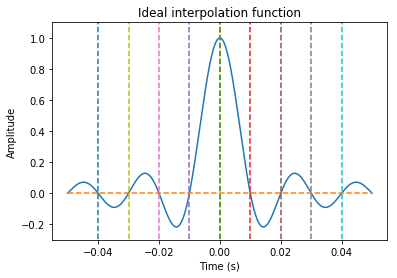

In [17]:
T = 1/100.
t = np.linspace(-5 * T, 5 * T, int(1e6)) # Let us use a very high resolution
g = np.sinc(t / T)
plt.plot(t, g)
plt.ylim(-0.3, 1.1)
for ind in range(5):
    plt.plot([ind * T, ind * T],[-0.4, 1.1], '--')
    plt.plot([-ind * T, -ind * T],[-0.4, 1.1], '--')
plt.plot([-5 * T, 5 * T], [0, 0], '--')

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Ideal interpolation function")

- Let us now draw several sinc functions shifted in time by $T$ and see that peaks of an individual sinc align with zeros of shifted sinc functions

Text(0.5,1,'Sinc functions')

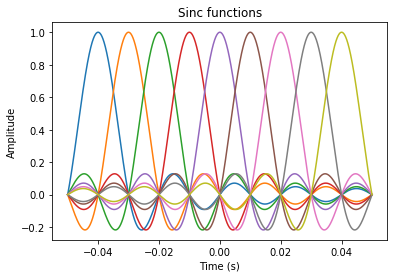

In [48]:
T = 1/100.
t = np.linspace(-5 * T, 5 * T, int(1e6)) # Let us use a very high resolution
for ind in range(-4,5):
    g = np.sinc((t - ind * T) / T)
    plt.plot(t, g)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Sinc functions")

- Let us now define some of the functions that we will use in our examples.
- Please document your code better than I do. PEP257 is a good point to start (https://www.python.org/dev/peps/pep-0257/)

In [29]:
def sampling(sigfun, T, nmin, nmax): # Given a signal generator function handle sigfun(), sample the signal generated by that function
    n = np.arange(nmin, nmax+1)
    sigsamp = sigfun(n * T)
    return sigsamp

def interpolation(sigsamp, t, T): # Ideal interpolation from a sampled signal
    nlen = len(sigsamp)
    tlen = len(t)
    out = np.zeros(tlen)
    for ind in range(nlen):
        out += sigsamp[ind] * np.sinc((t - ind * T) / T)
    return out

def somesig(t): # Some arbitrary, slowly changing polynomial signal that we will use as an example. 
    return 5 * t**3 - 20 * t**2 + 30 * t + 7

def samplehold(sigsamp, T, tax, outFs): # Sample/hold for the output stage.
    outsig = []
    for t in tax:
        n = int(t/T)
        val = sigsamp[n]
        outsig.append(val)
    return np.array(outsig)

def sampholdresponse(outF, T): # We will use this function to visualise the frequency response of the sample/hold stage
    Gsh = []
    for F in outF:
        Gsh.append(T * np.exp(-1j * np.pi * F * T) * np.sinc(F * T))
    return np.array(Gsh)

def idealresponse(outF, T): # This will generate the ideal (rect/top-hat/boxcar) response
    Gid = np.zeros(len(outF))
    Gid[abs(outF)<=1/(2*T)] = T
    return Gid

def antipostaliasresponse(Gid, Gsh, T): # This will give us the magnitude response of the post-alias cancellation filter
    Gapa = np.zeros(len(Gid), dtype=complex)
    Gapa[abs(Gid)!=0] = 1 / Gsh[abs(Gid)!=0]
    return Gapa
    

- Let us first plot our polynomial signal

Text(0.5,1,'Original signal')

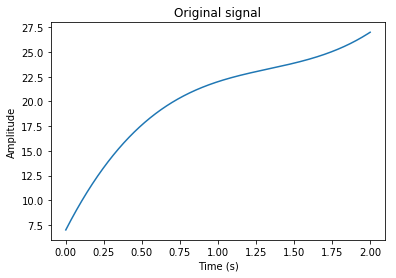

In [47]:
t = np.linspace(0, 2, int(1e6))
plt.plot(t, somesig(t))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original signal")

- Let us now sample our toy signal and plot the generated samples.

Text(0.5,1,'Sampled signal')

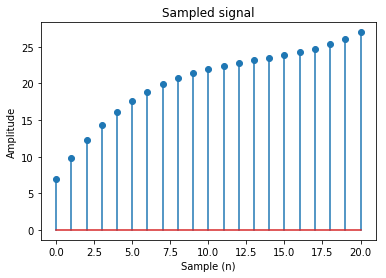

In [46]:
T = 0.1 # Sampling rate is 10 Hz
sigsamp = sampling(somesig, T, 0, 20)
plt.stem(sigsamp)
plt.xlabel("Sample (n)")
plt.ylabel("Amplitude")
plt.title("Sampled signal")

- We will now use the ideal interpolation function to try and obtain back the original signal that we sampled.
- In the figure you will see that the blue curve is the reconstructed signal, while the dotted orange curve is the original signal that we want to reconstruct. The interpolated signal does not match the original signal exactly.
- No, I was not fooling you during the lecture that sinc provides ideal interpolation! It does... or it would have, if we had more samples so that the first and last couple of samples also had contributions from their neigboring samples.
- The error is due to the ideal interpolation function being acausal and having an infinite time support.
- Also observe how sinc functions are temporally positioned in alignment with discrete samples.

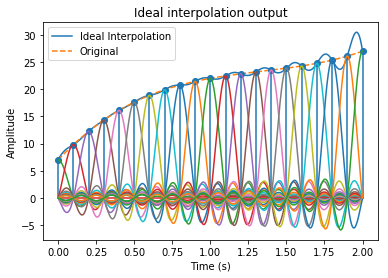

In [42]:
recout = interpolation(sigsamp, t, T)
plt.plot(t, recout, label='Ideal Interpolation')
plt.plot(t, somesig(t), '--', label='Original')
plt.stem(np.arange(21) * T, sigsamp)

for ind in range(21):
    plt.plot(t, sigsamp[ind] * np.sinc((t - ind * T) / T))

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Ideal interpolation output")
plt.legend()

- Let us now show that output of the sample/hold circuit will follow the original signal

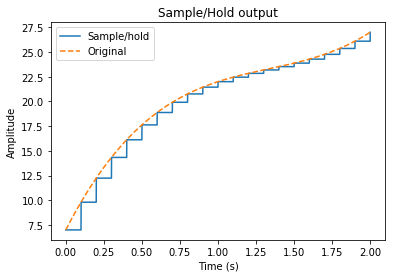

In [41]:
so = samplehold(sigsamp, T, t, int(1e6))
plt.plot(t, so, label='Sample/hold')
plt.plot(t, somesig(t), '--', label='Original')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Sample/Hold output")
plt.legend()

- We will not plot the magnitude response of the sample/hold circuit (blue) and that of ideal interpolation (orange)
- Observe the post-aliasing components!

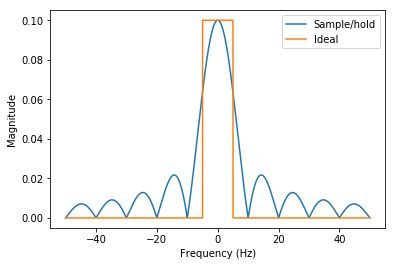

In [39]:
outF = np.linspace(-50, 50, int(1e6))
Gsh = sampholdresponse(outF, T)
Gid = idealresponse(outF, T)
plt.plot(outF, np.abs(Gsh), label='Sample/hold')
plt.plot(outF, Gid, label='Ideal')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

- Finally, we show the ideal anti-post-aliasing filter. Since this filter is still bandlimited, it cannot be implemented as a causal filter. However, causal approximations can be obtained which will minimise, but not completely eliminate the post-aliasing components.

Text(0.5,1,'Ideal anti-aliasing filter')

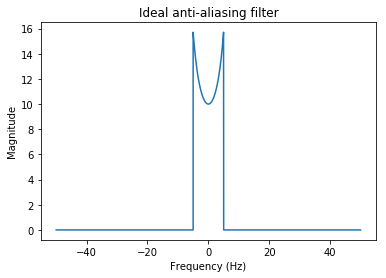

In [43]:
Gapa = antipostaliasresponse(Gid, Gsh, T)
plt.plot(outF,np.abs(Gapa))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Ideal anti-aliasing filter")

#### © 2020, Huseyin Hacihabiboglu, (hhuseyin@metu.edu.tr), METU Graduate School of Informatics